# 1. Import and Install Dependencies

## 1.1 Install Dependencies

## 1.2 Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf 
import tensorflow_io as tfio

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [2]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

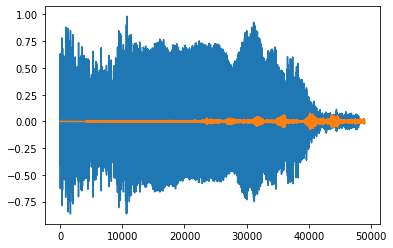

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [6]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [7]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [8]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [9]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [10]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [11]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [12]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [13]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [14]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [15]:
spectrogram, label = preprocess(filepath, label)

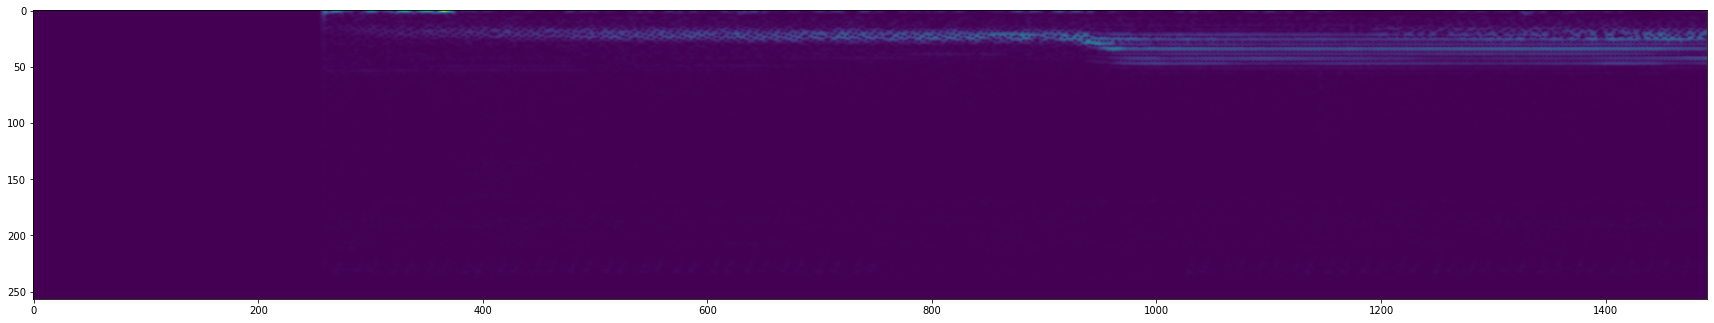

In [16]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [17]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [18]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [19]:
samples, labels = train.as_numpy_iterator().next()

In [20]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [23]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

ResourceExhaustedError: OOM when allocating tensor with shape[6019376,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

: 

In [ ]:
model.summary()

: 

## 7.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

: 

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

: 

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

: 

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

: 

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

: 

In [ ]:
yhat = model.predict(X_test)

: 

## 8.2 Convert Logits to Classes 

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

: 

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

: 

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

: 

In [ ]:
wav = load_mp3_16k_mono(mp3)

: 

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

: 

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

: 

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

: 

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

: 

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

: 

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

: 

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

: 

In [ ]:
calls

: 

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

: 

In [ ]:
results

: 

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

: 

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

: 

# 11. Export Results

In [ ]:
import csv

: 

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

: 